In [1]:
%matplotlib inline

# Evaluating robustness of Multivariate Hyperbolic Secant Mixture model(HSMM)
+ This notebook compares HSMM with Gaussian Mixture Model (GMM) in terms of counting correct labeling.

## Method:
+ As the cluster distribution, the following distributions are used, and compare clustering performance:


1. Gaussian distribution
1. Hyperbolic secant distribution
1. Laplace distribution
1. Gumbel distribution
1. Student distribution
1. Cauchy distribution
1. Gamma distribution
1. Skew Normal distribution
1. Parato distribution

### Suplementary material: Local Variational Approximation algorithm for HSMM
+ Model:
    + $p(x|w) = \sum_{k=1}^K a_k \prod_{j = 1}^M \frac{\sqrt{s_{kj}}}{2} \frac{1}{\cosh(\frac{s_{kj}}{2}(x_j - b_{kj}))}$
    + $x, b_k \in \mathbb{R}^M, s_k \in \mathbb{R}_+^M$
+ Prior distribution:
    + $\varphi(w) = Dir(a|\{ \alpha_k \}_{k=1}^K) \prod_{k=1}^K N(b_k|0, (s_k \beta_k)^{-1} ) Gam(s_k|\gamma_k, \delta_k)$
+ Algorithm
   1. Initializing the following values:
       + $g_{ikj}(\eta), v_{ikj}(\eta), h_{ik}(\xi), u_{ik}(\xi)$
   2. Update the following values
       + $\hat{\alpha}_k = \alpha_k + \sum_{i=1}^n u_{ik}(\xi)$
       + $\hat{\beta}_{kj} = \beta_k + \sum_{i=1}^n -2v_{ikj}(\eta)$
       + $\hat{m}_{kj} = \frac{1}{\hat{\beta}_k} \sum_{i=1}^n -2v_{ik}(\eta)x_i$
       + $\hat{\gamma}_{kj} = \gamma_k + \frac{1}{2}\sum_{i=1}^n u_{ik}(\xi)$
       + $\hat{\delta}_{kj} = \delta_k + \sum_{i=1}^n -v_{ikj}(\eta)x_{ij}^2 - \frac{\hat{\beta}_{kj}}{2}\hat{m}_{kj}^2$
   3. Update the following values
       + $g_{ikj}(\eta) = \frac{\hat{\gamma}_{kj}}{\hat{\delta}_{kj}} (x_{ij} - \hat{m}_{kj})^2 + \frac{1}{\hat{\beta}_{kj}}$
       + $v_{ikj}(\eta) = -u_{ik}(\xi)\frac{ \tanh(\sqrt{g_{ikj}(\eta)}/2) }{4\sqrt{g_{ikj}(\eta)}}$
   4. Update the following values
       + $h_{ik}(\xi) = \psi(\hat{\alpha}_k) - \psi(\sum_{l=1}^K \hat{\alpha}_l) + \frac{1}{2} \sum_{j=1}^M (\psi(\hat{\gamma}_{kj}) - \log(\hat{\delta}_{kj})) - \sum_{j=1}^M \log(\cosh(\sqrt{g_{ikj}(\eta)}/2)) $
       + $u_{ik}(\xi) = \frac{ \exp(h_{ik}(\xi)) }{ \sum_{l=1}^K \exp(h_{il}(\xi)) }$
       + where,$\psi(x) = \frac{d}{dx}\log \Gamma(x)$
   5. Return back to 2.
   
+ Evaluation function $\overline{F}_{\xi, \eta}(x^n)$:
    + $\overline{F}_{\xi, \eta}(x^n) = - \phi(h(\xi)) - \psi(g(\eta)) + u(\xi) \cdot h(\xi) + v(\eta) \cdot g(\eta) $  
        $+ nM \log 2 \pi + \log \Gamma(\sum_{l = 1}^K \hat{\alpha}_l) - \log \Gamma({\sum_{l = 1}^K\alpha}_l) + \sum_{k=1}^K \log \frac{\Gamma(\alpha_k)}{\Gamma(\hat{\alpha}_k)}$  
        $+ \sum_{k=1}^K \sum_{j=1}^M \bigl\{ \frac{1}{2} \log \frac{\hat{\beta}_{kj}}{\beta_{kj}} + \hat{\gamma}_{kj} \log \hat{\delta}_{kj} - \gamma_{kj} \log \delta_{kj} - \log \Gamma(\hat{\gamma}_{kj}) + \log \Gamma(\gamma_{kj}) \bigr\}$

In [32]:
from IPython.core.display import display, Markdown, Latex
import math
import numpy as np
from scipy.special import gammaln, psi
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, t, cauchy, laplace, gumbel_r, gamma, skewnorm, pareto

## Used funtions

In [3]:
def printmd(x):
    display(Markdown(x))

In [4]:
def random_hsm(n, loc = 0, scale = 1):
    """
    Generate data following hyperbolic secant distribution.
    Let $Y \sim standard_cauchy(x)$,  
    random variable $X = \frac{2}{s}\sinh^{-1}(Y) + b$ follows to  
    $X \sim p(x) = \frac{s}{2\pi}\frac{1}{\cosh(s(x-b)/2)}$.
    """
    Y = np.random.standard_cauchy(size=n)
    X = 2/np.sqrt(scale)*np.arcsinh(Y) + loc    
    return X

In [5]:
def fit_lva_gmm(train_X:np.ndarray, K:int,
                 pri_alpha = 0.1, pri_beta = 0.001, pri_gamma = 2, pri_delta = 2,
                 iteration = 1000, restart_num:int = 5, learning_seeds:list = None):
    """
    LVA for GMM.
    This is same with Variational Bayes inference for GMM.
    Since the algorithm fails to local minima, the best estimator are chosen in several initial values.
    
    + Input:
        + train_X: input data
        + pri_alpha: hyperparameter for prior distribution of symmetric Dirichlet distribution.
        + pri_beta: hyperparameter for prior distribution of Normal distribution for inverse variance.
        + pri_gamma: hyperparameter for prior distribution of Gamma distribution for shape parameter.
        + pri_delta: hyperparameter for prior distribution of Gamma distribution for rate parameter.
        + iteration: Number of iteration.
        + restart_num: Number of restart of inital values.
        + learning_seeds: Seeds for initial values.
        
    + Output:
        + Dictionary of the best estimated result:
            1. alpha: parameter for posterior distribution of Dirichlet distribution.
            2. mu: parameter for posterior distribution of Normal distribution for mean parameter.
            3. beta: parameter for posterior distribution of Normal distribution for inverse variance parameter.
            4. gamma: parameter for posterior distribution of Gamma distribution for shape parameter.
            5. delta: parameter for posterior distribution of Gamma distribution for rate parameter.
            6. h_xi: Value of E_w[log p(x_i, z_i = k|w)], where z_i is latent variable. This parameters form posterior latent distribution.
            7. u_xi: Value of p(z_i = k). This parameters represent posterior probability of latent variable
            8. energy: Value of the best evaluation function.
            9. seed: Value of the best learning seed.
    """
    
    (n, M) = train_X.shape
    ### Setting for static variable in the algorithm.
    expand_x = np.repeat(x, K).reshape(n, M, K).transpose((0, 2, 1)) ### n * K * M data with the same matrix among 2nd dimension

    min_energy = np.inf
    result = dict()
    
    for restart in range(restart_num):
        ### Set learning seed if learning_seeds is specified.
        if learning_seeds is not None and len(learning_seeds) >= restart:
            np.random.seed(learning_seeds[restart])

        energy = np.zeros(iteration)
        ### Setting for initial value
        est_u_xi = np.random.dirichlet(alpha = np.ones(K), size=n)
    
        ### Start learning.
        for ite in range(iteration):
            ### Update posterior distribution of parameter.
            est_alpha = pri_alpha + est_u_xi.sum(axis = 0)
            est_beta = np.repeat(pri_beta + est_u_xi.sum(axis = 0), M).reshape(K,M)
            est_m = est_u_xi.T @ x / est_beta
            est_gamma = np.repeat(pri_gamma + est_u_xi.sum(axis = 0)/2, M).reshape(K,M)
            est_delta = pri_delta + est_u_xi.T @ (x**2) /2 - est_beta / 2 * est_m**2
            
            ### Update posterior distribution of latent variable
            est_g_eta = np.repeat(est_gamma / est_delta, n).reshape(K,M,n).transpose((2,0,1)) * (expand_x - np.repeat(est_m,n).reshape(K,M,n).transpose((2,0,1)))**2 + 1/np.repeat(est_beta, n).reshape(K,M,n).transpose((2,0,1))
            est_h_xi = -M/2*np.log(2*np.pi) + np.repeat(psi(est_alpha) - psi(est_alpha.sum()) + (psi(est_gamma) - np.log(est_delta)).sum(axis = 1)/2, n).reshape(K,n).T - est_g_eta.sum(axis = 2)/2
            max_h_xi = est_h_xi.max(axis = 1)
            norm_h_xi = est_h_xi - np.repeat(max_h_xi,K).reshape(n,K)
            est_u_xi = np.exp(norm_h_xi) / np.repeat(np.exp(norm_h_xi).sum(axis = 1), K).reshape(n,K)

            ### Calculate evaluation function
            energy[ite] = - (np.log(np.exp(norm_h_xi).sum(axis = 1)) + max_h_xi).sum() + (est_u_xi * est_h_xi).sum()
            energy[ite] += gammaln(est_alpha.sum()) - gammaln(K*pri_alpha) + (-gammaln(est_alpha) + gammaln(pri_alpha)).sum()
            energy[ite] += (np.log(est_beta/pri_beta)/2 + est_gamma * np.log(est_delta) - pri_gamma * np.log(pri_delta) - gammaln(est_gamma) + gammaln(pri_gamma)).sum()
        
        print(energy[-1])        
        if energy[-1] < min_energy:
            min_energy = energy[-1]
            result["alpha"] = est_alpha
            result["mu"] = est_m
            result["beta"] = est_beta
            result["gamma"] = est_gamma
            result["delta"] = est_delta
            result["h_xi"] = est_h_xi
            result["u_xi"] = est_u_xi
            result["energy"] = energy
            if learning_seeds is not None and len(learning_seeds) >= restart:
                result["seed"] = learning_seeds[restart]
    return result

In [6]:
def fit_lva_hsmm(train_X:np.ndarray, K:int,
                 pri_alpha = 0.1, pri_beta = 0.001, pri_gamma = 2, pri_delta = 2,
                 iteration = 1000, restart_num:int = 5, learning_seeds:list = None):
    """
    LVA for HSMM.
    The algorithm is described in the above cell.
    Since the algorithm fails to local minima, the best estimator are chosen in several initial values.
    
    + Input:
        + train_X: input data
        + pri_alpha: hyperparameter for prior distribution of symmetric Dirichlet distribution.
        + pri_beta: hyperparameter for prior distribution of Normal distribution for inverse variance.
        + pri_gamma: hyperparameter for prior distribution of Gamma distribution for shape parameter.
        + pri_delta: hyperparameter for prior distribution of Gamma distribution for rate parameter.
        + iteration: Number of iteration.
        + restart_num: Number of restart of inital values.
        + learning_seeds: Seeds for initial values.
        
    + Output:
        + Dictionary of the best estimated result:
            1. alpha: parameter for posterior distribution of Dirichlet distribution.
            2. mu: parameter for posterior distribution of Normal distribution for mean parameter.
            3. beta: parameter for posterior distribution of Normal distribution for inverse variance parameter.
            4. gamma: parameter for posterior distribution of Gamma distribution for shape parameter.
            5. delta: parameter for posterior distribution of Gamma distribution for rate parameter.
            6. h_xi: Value of E_w[log p(x_i, z_i = k|w)], where z_i is latent variable. This parameters form posterior latent distribution.
            7. u_xi: Value of p(z_i = k). This parameters represent posterior probability of latent variable.
            8. g_eta: Value of auxiliary variable, which represents g(\eta) in the algorithm.
            9. v_eta: Value of auxiliary variable, which represents v(\eta) in the algorithm.
            10. energy: Value of the best evaluation function.
            11. seed: Value of the best learning seed.
    """    
    
    (n, M) = train_X.shape
    ### Setting for static variable in the algorithm.
    expand_x = np.repeat(x, K).reshape(n, M, K).transpose((0, 2, 1)) ### n * K * M data with the same matrix among 2nd dimension

    min_energy = np.inf
    result = dict()
    
    for restart in range(restart_num):
        ### Set learning seed if learning_seeds is specified.
        if learning_seeds is not None and len(learning_seeds) >= restart:
            np.random.seed(learning_seeds[restart])

        energy = np.zeros(iteration)
        ### Setting for initial value
        est_u_xi = np.random.dirichlet(alpha = np.ones(K), size=n)

        est_g_eta = np.abs(np.random.normal(size=(n,K,M)))
        est_v_eta = - np.repeat(est_u_xi, M).reshape(n, K, M) * np.tanh(np.sqrt(est_g_eta)/2)/(4*np.sqrt(est_g_eta))

        ### Start learning.
        for ite in range(iteration):
            ### Update posterior distribution of parameter
            est_alpha = pri_alpha + est_u_xi.sum(axis = 0)
            est_beta = pri_beta + (-2*est_v_eta.sum(axis = 0))
            est_m = -2 * (expand_x * est_v_eta).sum(axis = 0) / est_beta
            est_gamma = np.repeat(pri_gamma + est_u_xi.sum(axis = 0)/2, M).reshape(K,M)
            est_delta = pri_delta - (expand_x**2 * est_v_eta).sum(axis = 0) - est_beta / 2 * est_m**2
            
            ### Update auxiliary variables
            est_g_eta = np.repeat(est_gamma / est_delta, n).reshape(K,M,n).transpose((2,0,1)) * (expand_x - np.repeat(est_m,n).reshape(K,M,n).transpose((2,0,1)))**2 + 1/np.repeat(est_beta, n).reshape(K,M,n).transpose((2,0,1))
            est_v_eta = - np.repeat(est_u_xi, M).reshape(n, K, M) * np.tanh(np.sqrt(est_g_eta)/2)/(4*np.sqrt(est_g_eta))

            ### Update posterior distribution of latent variable
            sqrt_g_eta = np.sqrt(est_g_eta)
            est_h_xi = np.repeat(psi(est_alpha) - psi(est_alpha.sum()) + (psi(est_gamma) - np.log(est_delta)).sum(axis = 1)/2, n).reshape(K,n).T - (sqrt_g_eta/2 +  np.log( (1 + np.exp(-2*sqrt_g_eta/2 ))/2)).sum(axis = 2)
            max_h_xi = est_h_xi.max(axis = 1)
            norm_h_xi = est_h_xi - np.repeat(max_h_xi,K).reshape(n,K)
            est_u_xi = np.exp(norm_h_xi) / np.repeat(np.exp(norm_h_xi).sum(axis = 1), K).reshape(n,K)

            ### Calculate evaluation function
            energy[ite] = (np.repeat(est_u_xi, M).reshape(n, K, M) * (sqrt_g_eta/2 +  np.log( (1 + np.exp(-2*sqrt_g_eta/2 ))/2)) ).sum() - (np.log(np.exp(norm_h_xi).sum(axis = 1)) + max_h_xi).sum() + (est_u_xi * est_h_xi).sum() + (est_v_eta * est_g_eta).sum()
            energy[ite] += gammaln(est_alpha.sum()) - gammaln(K*pri_alpha) + (-gammaln(est_alpha) + gammaln(pri_alpha)).sum()
            energy[ite] += (np.log(est_beta/pri_beta)/2 + est_gamma * np.log(est_delta) - pri_gamma * np.log(pri_delta) - gammaln(est_gamma) + gammaln(pri_gamma)).sum()
        
        print(energy[-1])        
        if energy[-1] < min_energy:
            min_energy = energy[-1]
            result["alpha"] = est_alpha
            result["beta"] = est_beta
            result["mu"] = est_m
            result["gamma"] = est_gamma
            result["delta"] = est_delta
            result["h_xi"] = est_h_xi
            result["u_xi"] = est_u_xi
            result["g_eta"] = est_g_eta
            result["v_eta"] = est_v_eta            
            result["energy"] = energy
            if learning_seeds is not None and len(learning_seeds) >= restart:
                result["seed"] = learning_seeds[restart]
    return result

In [7]:
import itertools
def evaluate_correct_cluster_number(result:dict, noise_data_num:int, true_label_arg, K:int):    
    est_label_prob = result["u_xi"]
    if noise_data_num > 0:
        target_label_arg = true_label_arg[:-noise_data_num]
        est_label_arg = np.argmax(est_label_prob, axis = 1)[:-noise_data_num]
    else:
        target_label_arg = true_label_arg
        est_label_arg = np.argmax(est_label_prob, axis = 1)

    max_correct_num = 0
    for perm in list(itertools.permutations(range(K), K)):
        permed_est_label_arg = est_label_arg.copy()
        for i in range(len(perm)):
            permed_est_label_arg[est_label_arg == i] = perm[i]
        correct_num = (permed_est_label_arg == target_label_arg).sum()
        if correct_num > max_correct_num:
            max_correct_num = correct_num
            max_perm = perm
            max_est_label_arg = permed_est_label_arg
    return (max_correct_num, max_perm, max_est_label_arg)

In [8]:
def learning_and_labeling():
    printmd("### 1. Data distribution:")
    plot_scatter_with_label(x, true_label_arg,  K0, noise_data_num)

    printmd("### 2. Learning by GMM:")
    gmm_result = fit_lva_gmm(x, K, pri_alpha = pri_alpha, pri_beta = pri_beta, pri_gamma = pri_gamma, pri_delta = pri_delta, learning_seeds = learning_seeds)
    print("mean plug-in parameters: \n {0}".format({
        "est_ratio": gmm_result["alpha"] / sum(gmm_result["alpha"]),
        "est_mean": gmm_result["mu"],
        "est_precision": gmm_result["gamma"] / gmm_result["delta"]
    }))
    (correct_num_gmm, perm_gmm, label_arg_gmm) = evaluate_correct_cluster_number(gmm_result, noise_data_num, true_label_arg, K)

    printmd("### 3.. Learning by HSMM:")
    hsmm_result = fit_lva_hsmm(x, K, pri_alpha = pri_alpha, pri_beta = pri_beta, pri_gamma = pri_gamma, pri_delta = pri_delta, learning_seeds=learning_seeds)
    print("mean plug-in parameters: \n {0}".format({
        "est_ratio": hsmm_result["alpha"] / sum(hsmm_result["alpha"]),
        "est_mean": hsmm_result["mu"],
        "est_precision": hsmm_result["gamma"] / hsmm_result["delta"]
    }))
    (correct_num_hsmm, perm_hsmm, label_arg_hsmm) = evaluate_correct_cluster_number(hsmm_result, noise_data_num, true_label_arg, K)

    printmd("### 4. Correct number of labeling of GMM:")
    printmd("+ {0}/{1}".format(correct_num_gmm, len(label_arg_hsmm)))

    printmd("### 5. Correct number of labeling of HSMM:")
    printmd("+ {0}/{1}".format(correct_num_hsmm, len(label_arg_hsmm)))

    printmd("### 6. Data distribution labeled by GMM:")
    plot_scatter_with_label(x, label_arg_gmm,  K, noise_data_num)

    printmd("### 7. Data distribution labeled by HSMM:")
    plot_scatter_with_label(x, label_arg_hsmm,  K, noise_data_num)

In [9]:
def plot_scatter_with_label(x:np.ndarray, label_arg:np.ndarray,  K:int, noise_data_num):
    """
    Scatter plot for data x
    """
    for i in range(K):
        if noise_data_num > 0:
            plt.scatter(x[np.where(label_arg[:-noise_data_num] == i)[0],0], x[np.where(label_arg[:-noise_data_num] == i)[0],1])
        else:
            plt.scatter(x[np.where(label_arg == i)[0],0], x[np.where(label_arg == i)[0],1])        
    plt.show()

## Problem setting:

In [10]:
data_seed = 20190522
true_ratio = np.array([0.33, 0.33, 0.34])
true_delta = 0
true_s = np.array([[2, 2], [0.5, 0.5], [1, 1]])
true_b = np.array([[4, 4], [-4, -4], [0, 0]])
n = 2000
M = true_b.shape[1]
K0 = len(true_ratio)
np.random.seed(data_seed)

## Learning setting:

In [11]:
### Iteration settings
iteration = 1000
learning_seeds = [20190511, 20190512, 20190513, 20190514, 20190515]

## Number of components for cluster
K = 5

## Hyperparameters
pri_alpha = 0.1
pri_beta = 0.001
pri_gamma = 3
pri_delta = 3

### Label setting for each data
+ Remark: Label is fixed through each cluster distribution.

In [12]:
true_label = np.random.multinomial(n = 1, pvals = true_ratio, size = n)
true_label_arg = np.argmax(true_label, axis = 1)

## 1. Cluster distribution is Gaussian distribution

In [13]:
np.random.seed(data_seed)
x = np.zeros((n, M))
for i in range(n):
    for j in range(M):
        x[i, j] = norm.rvs(loc=true_b[true_label_arg[i],j], scale=true_s[true_label_arg[i],j], size = 1)

noise_data_num = math.ceil(n*true_delta)
if noise_data_num > 0:
    x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)

### 1. Data distribution:

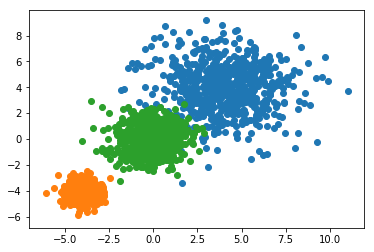

### 2. Learning by GMM:

4236.485074990098
4236.483319527365
4249.074250056185
4236.485074990098
4236.485074990098
mean plug-in parameters: 
 {'est_ratio': array([3.21481685e-01, 3.53382861e-01, 4.99875031e-05, 4.99875031e-05,
       3.25035479e-01]), 'est_mean': array([[-3.97009637e+00, -4.04911386e+00],
       [-5.66927183e-02, -1.86957627e-03],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 4.00448570e+00,  3.96919801e+00]]), 'est_precision': array([[3.85816705, 3.6547192 ],
       [0.87188573, 0.94737793],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [0.24709742, 0.29979674]])}


### 3.. Learning by HSMM:

770.0769858021154
770.0769858020831
770.0769858021013
770.0769858020578
770.0769858020371
mean plug-in parameters: 
 {'est_ratio': array([3.21905645e-01, 3.63400988e-01, 4.99875031e-05, 3.14593392e-01,
       4.99875031e-05]), 'est_mean': array([[-3.95395055e+00, -4.04459770e+00],
       [ 3.92907517e-03,  4.14524941e-02],
       [ 2.22876166e-16,  2.12323486e-16],
       [ 4.08463828e+00,  4.06769024e+00],
       [ 2.22876166e-16,  2.12323486e-16]]), 'est_precision': array([[23.29881093, 22.73324549],
       [ 6.51509651,  6.89451979],
       [ 1.        ,  1.        ],
       [ 2.16038274,  2.57448006],
       [ 1.        ,  1.        ]])}


### 4. Correct number of labeling of GMM:

+ 1961/2000

### 5. Correct number of labeling of HSMM:

+ 1964/2000

### 6. Data distribution labeled by GMM:

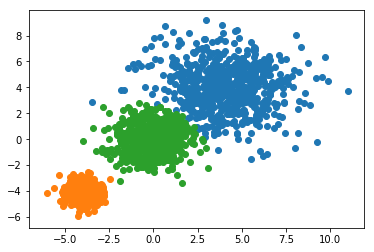

### 7. Data distribution labeled by HSMM:

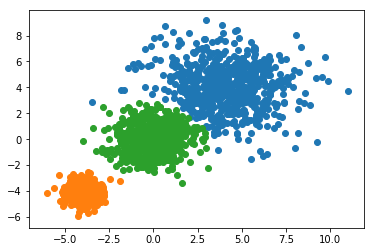

In [14]:
learning_and_labeling()

### 1. Data distribution:

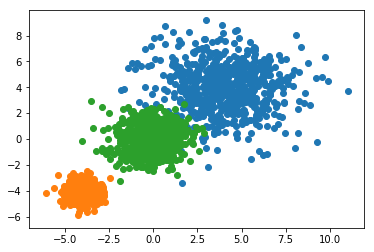

### 2. Learning by GMM:

4236.485074990098
4236.483319527365
4249.074250056185
4236.485074990098
4236.485074990098
mean plug-in parameters: 
 {'est_ratio': array([3.21481685e-01, 3.53382861e-01, 4.99875031e-05, 4.99875031e-05,
       3.25035479e-01]), 'est_mean': array([[-3.97009637e+00, -4.04911386e+00],
       [-5.66927183e-02, -1.86957627e-03],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 4.00448570e+00,  3.96919801e+00]]), 'est_precision': array([[3.85816705, 3.6547192 ],
       [0.87188573, 0.94737793],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [0.24709742, 0.29979674]])}


### 3.. Learning by HSMM:

770.0769858021154
770.0769858020831
770.0769858021013
770.0769858020578
770.0769858020371
mean plug-in parameters: 
 {'est_ratio': array([3.21905645e-01, 3.63400988e-01, 4.99875031e-05, 3.14593392e-01,
       4.99875031e-05]), 'est_mean': array([[-3.95395055e+00, -4.04459770e+00],
       [ 3.92907517e-03,  4.14524941e-02],
       [ 2.22876166e-16,  2.12323486e-16],
       [ 4.08463828e+00,  4.06769024e+00],
       [ 2.22876166e-16,  2.12323486e-16]]), 'est_precision': array([[23.29881093, 22.73324549],
       [ 6.51509651,  6.89451979],
       [ 1.        ,  1.        ],
       [ 2.16038274,  2.57448006],
       [ 1.        ,  1.        ]])}


### 4. Correct number of labeling of GMM:

+ 1961/2000

### 5. Correct number of labeling of HSMM:

+ 1964/2000

### 6. Data distribution labeled by GMM:

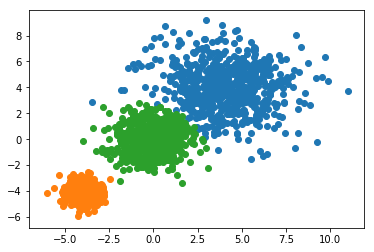

### 7. Data distribution labeled by HSMM:

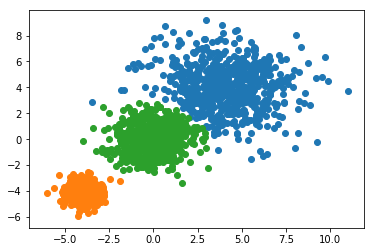

In [15]:
printmd("### 1. Data distribution:")
plot_scatter_with_label(x, true_label_arg,  K0, noise_data_num)

printmd("### 2. Learning by GMM:")
gmm_result = fit_lva_gmm(x, K, pri_alpha = pri_alpha, pri_beta = pri_beta, pri_gamma = pri_gamma, pri_delta = pri_delta, learning_seeds = learning_seeds)
print("mean plug-in parameters: \n {0}".format({
    "est_ratio": gmm_result["alpha"] / sum(gmm_result["alpha"]),
    "est_mean": gmm_result["mu"],
    "est_precision": gmm_result["gamma"] / gmm_result["delta"]
}))
(correct_num_gmm, perm_gmm, label_arg_gmm) = evaluate_correct_cluster_number(gmm_result, noise_data_num, true_label_arg, K)

printmd("### 3.. Learning by HSMM:")
hsmm_result = fit_lva_hsmm(x, K, pri_alpha = pri_alpha, pri_beta = pri_beta, pri_gamma = pri_gamma, pri_delta = pri_delta, learning_seeds=learning_seeds)
print("mean plug-in parameters: \n {0}".format({
    "est_ratio": hsmm_result["alpha"] / sum(hsmm_result["alpha"]),
    "est_mean": hsmm_result["mu"],
    "est_precision": hsmm_result["gamma"] / hsmm_result["delta"]
}))
(correct_num_hsmm, perm_hsmm, label_arg_hsmm) = evaluate_correct_cluster_number(hsmm_result, noise_data_num, true_label_arg, K)

printmd("### 4. Correct number of labeling of GMM:")
printmd("+ {0}/{1}".format(correct_num_gmm, len(label_arg_hsmm)))

printmd("### 5. Correct number of labeling of HSMM:")
printmd("+ {0}/{1}".format(correct_num_hsmm, len(label_arg_hsmm)))

printmd("### 6. Data distribution labeled by GMM:")
plot_scatter_with_label(x, label_arg_gmm,  K, noise_data_num)

printmd("### 7. Data distribution labeled by HSMM:")
plot_scatter_with_label(x, label_arg_hsmm,  K, noise_data_num)

## 2. Cluster distribution is Hyperbolic secant distribution

In [16]:
np.random.seed(data_seed)
x = np.zeros((n, M))
for i in range(n):
    for j in range(M):
        x[i, j] = random_hsm(n=1, loc=true_b[true_label_arg[i],j], scale=true_s[true_label_arg[i],j])

noise_data_num = math.ceil(n*true_delta)
if noise_data_num > 0:
    x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)

### 1. Data distribution:

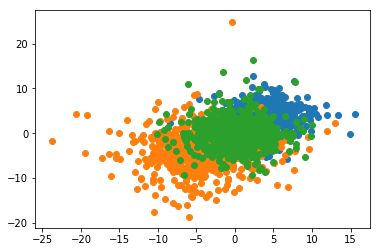

### 2. Learning by GMM:

7804.047470659013
7824.434027318153
7804.047470659028
7822.701440927538
7804.047470659068
mean plug-in parameters: 
 {'est_ratio': array([0.33169785, 0.00054986, 0.20381478, 0.27810445, 0.18583305]), 'est_mean': array([[-4.17701272, -3.77018025],
       [-0.32087089, 24.90573422],
       [ 3.76383112,  3.24806343],
       [-0.42924897, -0.55833113],
       [ 3.94712653,  4.09204931]]), 'est_precision': array([[0.05042241, 0.05424907],
       [1.16664661, 1.05725552],
       [0.08806221, 0.0864535 ],
       [0.16065581, 0.14708781],
       [0.4624887 , 0.46038393]])}


### 3.. Learning by HSMM:

4069.2024628979925
4056.7848145459056
4072.059004030183
4072.0625896700517
4069.0574287681584
mean plug-in parameters: 
 {'est_ratio': array([4.23973964e-01, 3.27863762e-01, 4.99875031e-05, 2.48062299e-01,
       4.99875031e-05]), 'est_mean': array([[-2.17627815e-01, -4.45650357e-01],
       [ 3.97755445e+00,  4.06369344e+00],
       [-3.24689975e-16,  5.79289505e-16],
       [-4.86759822e+00, -4.45949107e+00],
       [-3.24689975e-16,  5.79289505e-16]]), 'est_precision': array([[0.79477117, 0.89127478],
       [1.85459085, 2.02576745],
       [1.        , 1.        ],
       [0.56396687, 0.53643262],
       [1.        , 1.        ]])}


### 4. Correct number of labeling of GMM:

+ 1400/2000

### 5. Correct number of labeling of HSMM:

+ 1567/2000

### 6. Data distribution labeled by GMM:

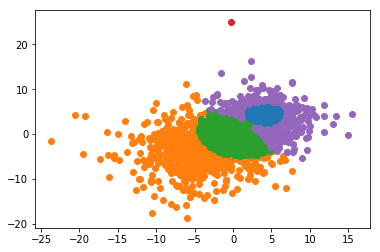

### 7. Data distribution labeled by HSMM:

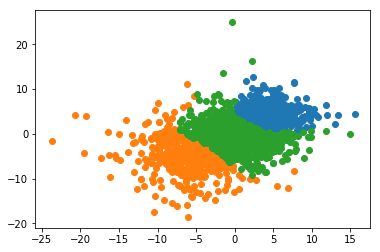

In [17]:
learning_and_labeling()

## 3. Cluster distribution is Laplace distribution

In [18]:
np.random.seed(data_seed)
x = np.zeros((n, M))
for i in range(n):
    for j in range(M):
        x[i, j] = laplace.rvs(loc=true_b[true_label_arg[i],j], scale=1/true_s[true_label_arg[i],j], size = 1)

noise_data_num = math.ceil(n*true_delta)
if noise_data_num > 0:
    x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)

### 1. Data distribution:

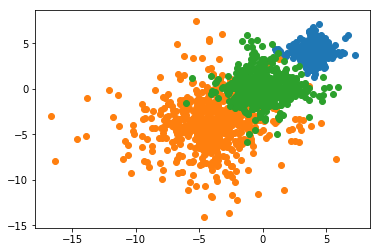

### 2. Learning by GMM:

5186.522521087993
5187.901429597403
5204.2087946333095
5187.901429597421
5186.522521087951
mean plug-in parameters: 
 {'est_ratio': array([0.19213361, 0.10462919, 0.30867251, 0.17394642, 0.22061826]), 'est_mean': array([[-3.98530421, -3.80931252],
       [-5.0435215 , -4.957041  ],
       [ 3.98120554,  4.05426877],
       [ 0.27004258,  0.544531  ],
       [-0.05909869,  0.00748933]]), 'est_precision': array([[0.40904175, 0.32461519],
       [0.08155913, 0.0939178 ],
       [3.02467737, 2.43810958],
       [0.1542631 , 0.16455292],
       [1.5476355 , 1.27281046]])}


### 3.. Learning by HSMM:

1487.5877805654438
1487.5877805654468
1487.5877805654582
1487.5877805654293
1487.587780565448
mean plug-in parameters: 
 {'est_ratio': array([4.99875031e-05, 3.51183391e-01, 3.19540789e-01, 4.99875031e-05,
       3.29175844e-01]), 'est_mean': array([[-6.23244369e-16, -4.70742193e-16],
       [-3.40437470e-02,  7.10081926e-02],
       [-4.09835813e+00, -3.93424526e+00],
       [-6.23244369e-16, -4.70742193e-16],
       [ 3.97077003e+00,  4.02457021e+00]]), 'est_precision': array([[ 1.        ,  1.        ],
       [ 5.17902569,  5.29906034],
       [ 1.53904465,  1.38950815],
       [ 1.        ,  1.        ],
       [17.99649677, 16.57482777]])}


### 4. Correct number of labeling of GMM:

+ 1566/2000

### 5. Correct number of labeling of HSMM:

+ 1933/2000

### 6. Data distribution labeled by GMM:

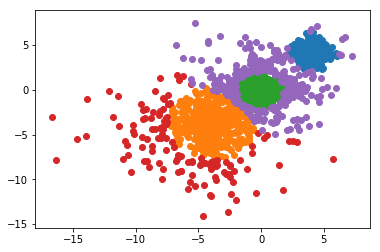

### 7. Data distribution labeled by HSMM:

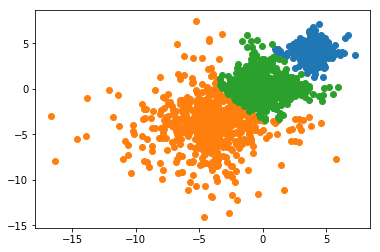

In [19]:
learning_and_labeling()

## 4. Cluster distribution is Gumbel distribution

In [20]:
np.random.seed(data_seed)
x = np.zeros((n, M))
for i in range(n):
    for j in range(M):
        x[i, j] = gumbel_r.rvs(loc=true_b[true_label_arg[i],j], scale=1/true_s[true_label_arg[i],j], size = 1)

noise_data_num = math.ceil(n*true_delta)
if noise_data_num > 0:
    x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)

### 1. Data distribution:

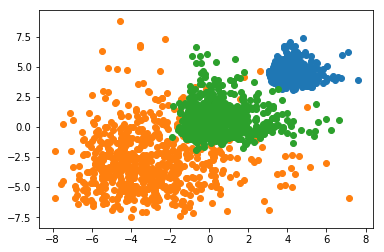

### 2. Learning by GMM:

4812.404858307804
4812.405012462452
4812.405020182732
4812.404893974849
4813.883665170435
mean plug-in parameters: 
 {'est_ratio': array([0.24644496, 0.13333857, 0.31688673, 0.09730097, 0.20602878]), 'est_mean': array([[-3.62591344, -3.43591319],
       [ 0.50237628,  0.89060326],
       [ 4.20752541,  4.28423651],
       [ 1.29645134,  0.19708591],
       [-0.03493299,  0.49503009]]), 'est_precision': array([[0.34260963, 0.28401515],
       [0.10206208, 0.10033187],
       [3.32049115, 2.78496207],
       [0.71204634, 1.41871121],
       [2.05201006, 0.73946227]])}


### 3.. Learning by HSMM:

1246.6771889510521
1243.9482278362223
1243.9482278362007
1235.1006661344038
1235.1006661344197
mean plug-in parameters: 
 {'est_ratio': array([0.40257831, 0.00768888, 0.14069005, 0.11481916, 0.3342236 ]), 'est_mean': array([[ 0.23234694,  0.36125868],
       [ 4.15021418, -3.0795005 ],
       [-3.06436558, -4.35242138],
       [-4.52120536, -2.21712161],
       [ 4.17283892,  4.23437541]]), 'est_precision': array([[ 4.66306559,  4.25311113],
       [ 1.84404168,  1.34666704],
       [ 2.43327048,  3.86752324],
       [ 4.49203349,  1.48863885],
       [18.82800056, 16.63556131]])}


### 4. Correct number of labeling of GMM:

+ 1629/2000

### 5. Correct number of labeling of HSMM:

+ 1659/2000

### 6. Data distribution labeled by GMM:

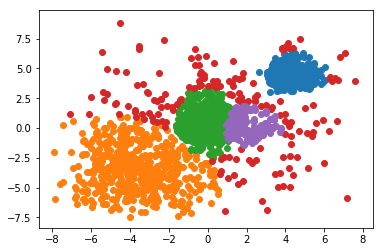

### 7. Data distribution labeled by HSMM:

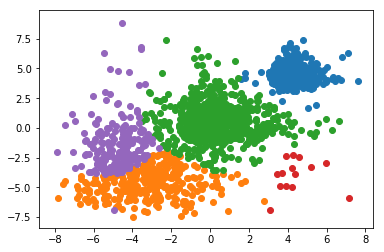

In [21]:
learning_and_labeling()

## 5. Cluster distribution is student distribution

In [22]:
np.random.seed(data_seed)
x = np.zeros((n, M))
for i in range(n):
    for j in range(M):
        x[i, j] = t.rvs(df = 1.5, loc=true_b[true_label_arg[i],j], scale=1/true_s[true_label_arg[i],j], size = 1)

noise_data_num = math.ceil(n*true_delta)
if noise_data_num > 0:
    x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)

### 1. Data distribution:

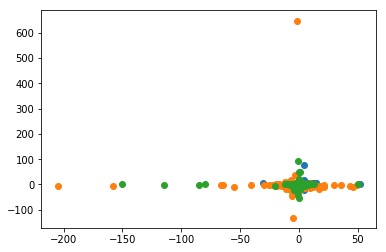

### 2. Learning by GMM:

6998.485182125579
6998.485182125582
6995.523852392892
6998.485182125572
6998.485182125566
mean plug-in parameters: 
 {'est_ratio': array([0.27514653, 0.28970027, 0.01798167, 0.22155067, 0.19562085]), 'est_mean': array([[ 4.06218876e+00,  3.96270182e+00],
       [-1.01119863e+00, -1.40358543e+00],
       [-2.23966019e+01,  1.45691304e+01],
       [-3.85320272e-03,  8.81304841e-03],
       [-3.45826249e+00, -3.75125343e+00]]), 'est_precision': array([[1.93305752e+00, 1.80970708e+00],
       [2.78793649e-02, 2.86122826e-02],
       [3.25359527e-04, 9.08974823e-05],
       [1.06064565e+00, 9.27846226e-01],
       [2.46352379e-01, 2.05369939e-01]])}


### 3.. Learning by HSMM:

3211.087784033999
3211.087784034015
3211.087784033962
3211.0877840339763
3201.5347215165243
mean plug-in parameters: 
 {'est_ratio': array([0.0326843 , 0.26078271, 0.31012582, 0.37969261, 0.01671456]), 'est_mean': array([[-2.86357999, -2.01304549],
       [ 0.03539666,  0.00792321],
       [ 4.02868955,  3.96785051],
       [-3.16487514, -3.43644521],
       [ 0.14936347,  0.52678058]]), 'est_precision': array([[7.46176433e-03, 4.21628477e-01],
       [5.40307849e+00, 4.92160394e+00],
       [1.05305793e+01, 1.01876312e+01],
       [6.94251790e-01, 6.03345338e-01],
       [7.38722160e-01, 3.43554366e-03]])}


### 4. Correct number of labeling of GMM:

+ 1411/2000

### 5. Correct number of labeling of HSMM:

+ 1707/2000

### 6. Data distribution labeled by GMM:

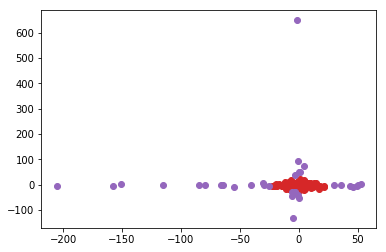

### 7. Data distribution labeled by HSMM:

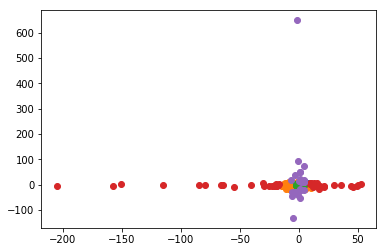

In [23]:
learning_and_labeling()

## 6. Cluster distribution is Cauchy distribution

In [24]:
np.random.seed(data_seed)
x = np.zeros((n, M))
for i in range(n):
    for j in range(M):
        x[i, j] = cauchy.rvs(loc=true_b[true_label_arg[i],j], scale=1/true_s[true_label_arg[i],j], size = 1)

noise_data_num = math.ceil(n*true_delta)
if noise_data_num > 0:
    x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)

### 1. Data distribution:

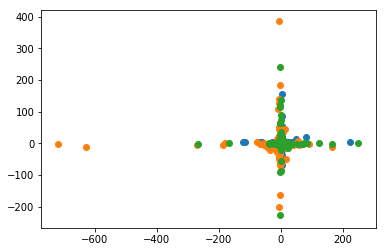

### 2. Learning by GMM:

8529.897614842412
8452.771146829575
8452.771146829578
8452.771146829567
8452.771146829578
mean plug-in parameters: 
 {'est_ratio': array([0.23828587, 0.23520346, 0.03722707, 0.03763988, 0.45164372]), 'est_mean': array([[ -1.57338374,  -0.85435186],
       [  3.99806412,   4.01796523],
       [-20.99036582,  -1.58125787],
       [ -0.7852951 ,  15.63658045],
       [ -1.21749322,  -1.06648462]]), 'est_precision': array([[1.84424534e-02, 1.64064109e-02],
       [2.03142829e+00, 1.89871994e+00],
       [5.57086919e-05, 3.11678030e-02],
       [4.73756263e-02, 1.39325270e-04],
       [1.26817820e-01, 1.29526328e-01]])}


### 3.. Learning by HSMM:

4604.278590681774
4512.5100564923
4604.278590681754
4512.510056492217
4512.510056492257
mean plug-in parameters: 
 {'est_ratio': array([0.07027965, 0.27962107, 0.05808873, 0.381408  , 0.21060255]), 'est_mean': array([[-0.62464444,  6.23545975],
       [ 3.983581  ,  4.02877976],
       [-0.56082052, -0.89490018],
       [-3.15318672, -2.78735419],
       [ 0.01860186,  0.14260973]]), 'est_precision': array([[4.22203792e-01, 4.08052868e-03],
       [1.00262507e+01, 8.97676774e+00],
       [1.98427180e-03, 3.24675718e-01],
       [5.18100104e-01, 5.23514308e-01],
       [5.48043888e+00, 4.22075601e+00]])}


### 4. Correct number of labeling of GMM:

+ 1247/2000

### 5. Correct number of labeling of HSMM:

+ 1499/2000

### 6. Data distribution labeled by GMM:

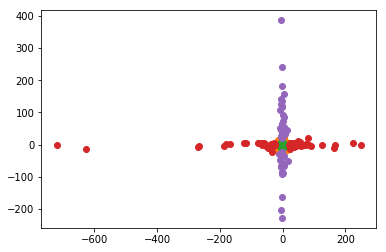

### 7. Data distribution labeled by HSMM:

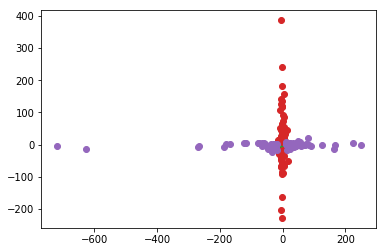

In [25]:
learning_and_labeling()

## 7. Cluster distribution is Gamma distribution
+ Remark: Actually support of gamma distribution is not whole real line, but scipy can generate data with loc on real value.

In [26]:
np.random.seed(data_seed)
x = np.zeros((n, M))
for i in range(n):
    for j in range(M):
        x[i, j] = gamma.rvs(a = 1, loc=true_b[true_label_arg[i],j], scale=1/true_s[true_label_arg[i],j], size = 1)

noise_data_num = math.ceil(n*true_delta)
if noise_data_num > 0:
    x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)

### 1. Data distribution:

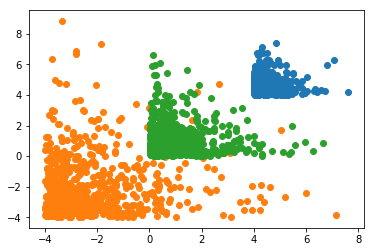

### 2. Learning by GMM:

3455.1593774252497
3455.159377425266
3500.7628764363512
3474.781101032062
3455.159377425288
mean plug-in parameters: 
 {'est_ratio': array([0.20857905, 0.23735734, 0.24081346, 0.08507123, 0.22817891]), 'est_mean': array([[-2.80858254, -2.76618246],
       [ 0.62238725,  0.76138647],
       [ 4.33544264,  4.35965362],
       [ 4.78514771,  4.99383002],
       [ 0.48201374,  0.62271724]]), 'est_precision': array([[ 1.26450627,  1.10623188],
       [ 4.19828048,  2.81396863],
       [12.26583313, 11.19810833],
       [ 2.45871579,  1.82479136],
       [ 0.17734892,  0.19199868]])}


### 3.. Learning by HSMM:

92.59247122918987
92.59247122919851
92.59247122922625
92.59247122909119
92.59247122916668
mean plug-in parameters: 
 {'est_ratio': array([0.33786397, 0.05530033, 0.18713989, 0.09061433, 0.32908149]), 'est_mean': array([[ 0.60158619,  0.78661339],
       [ 2.89565364,  0.58320134],
       [-2.62075151, -3.09021805],
       [-3.10986497, -0.71202805],
       [ 4.37525368,  4.42113028]]), 'est_precision': array([[15.60088165,  7.94882296],
       [ 2.55999198,  2.16573627],
       [ 5.36966212, 10.75724628],
       [ 9.03844035,  1.96924604],
       [32.30372419, 27.2445959 ]])}


### 4. Correct number of labeling of GMM:

+ 1455/2000

### 5. Correct number of labeling of HSMM:

+ 1703/2000

### 6. Data distribution labeled by GMM:

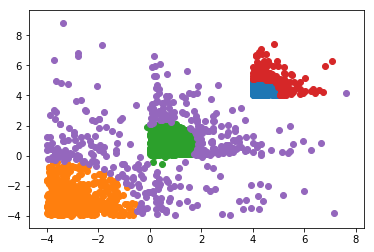

### 7. Data distribution labeled by HSMM:

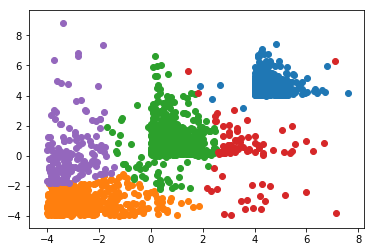

In [27]:
learning_and_labeling()

## 8. Cluster distribution is Skew Normal distribution

In [28]:
np.random.seed(data_seed)
x = np.zeros((n, M))
for i in range(n):
    for j in range(M):
        x[i, j] = skewnorm.rvs(a = 2, loc=true_b[true_label_arg[i],j], scale=1/true_s[true_label_arg[i],j], size = 1)

noise_data_num = math.ceil(n*true_delta)
if noise_data_num > 0:
    x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)

### 1. Data distribution:

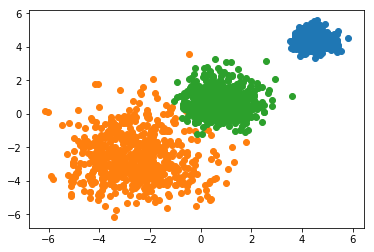

### 2. Learning by GMM:

2854.1690025318226
2854.1689412113246
2854.169141841143
2849.3923457237106
2849.3923462696143
mean plug-in parameters: 
 {'est_ratio': array([0.02147704, 0.33653213, 0.18153978, 0.13198643, 0.32846463]), 'est_mean': array([[ 0.91651872,  1.84314469],
       [ 0.68703759,  0.59473448],
       [-2.91550279, -1.95728264],
       [-2.41956235, -3.53751225],
       [ 4.36850598,  4.37459247]]), 'est_precision': array([[0.92575574, 1.35271321],
       [2.00949173, 2.07625029],
       [0.82243042, 0.56338997],
       [0.46006772, 1.45971151],
       [7.6014169 , 7.3976583 ]])}


### 3.. Learning by HSMM:

-476.16905112258974
-476.1690511227889
-476.16905112258746
-476.16905112246013
-476.16905112249424
mean plug-in parameters: 
 {'est_ratio': array([3.07607170e-01, 4.99875031e-05, 4.99875031e-05, 3.63598444e-01,
       3.28694411e-01]), 'est_mean': array([[-2.77694953e+00, -2.76070351e+00],
       [-7.24473758e-17, -5.35983676e-17],
       [-7.24473758e-17, -5.35983676e-17],
       [ 6.55844790e-01,  6.21361699e-01],
       [ 4.34937881e+00,  4.36105954e+00]]), 'est_precision': array([[ 4.73425388,  4.31311251],
       [ 1.        ,  1.        ],
       [ 1.        ,  1.        ],
       [13.12695546, 12.46261294],
       [38.23722872, 36.89000538]])}


### 4. Correct number of labeling of GMM:

+ 1674/2000

### 5. Correct number of labeling of HSMM:

+ 1972/2000

### 6. Data distribution labeled by GMM:

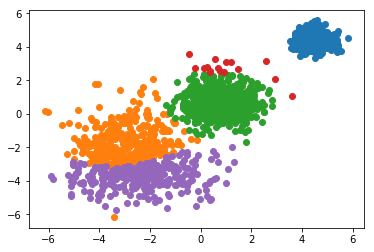

### 7. Data distribution labeled by HSMM:

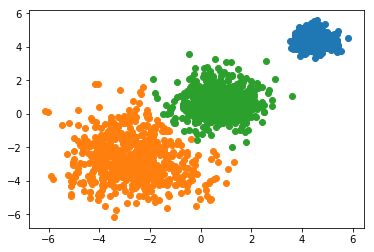

In [29]:
learning_and_labeling()

## 9. Cluster distribution is Parato distribution
+ Parato distribution has inifite variance if $shape \leq 2$.

In [33]:
np.random.seed(data_seed)
x = np.zeros((n, M))
for i in range(n):
    for j in range(M):
        x[i, j] = pareto.rvs(b = 1.5, loc=true_b[true_label_arg[i],j], scale=1/true_s[true_label_arg[i],j], size = 1)

noise_data_num = math.ceil(n*true_delta)
if noise_data_num > 0:
    x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)

### 1. Data distribution:

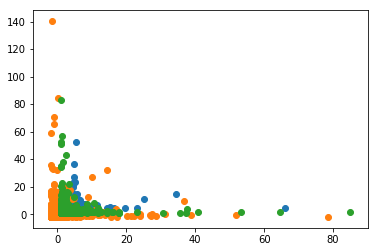

### 2. Learning by GMM:

5220.736251702147
5405.075985302846
5405.075985302887
5466.588633880503
5405.075985302958
mean plug-in parameters: 
 {'est_ratio': array([0.22158713, 0.25780331, 0.18666512, 0.25849508, 0.07544936]), 'est_mean': array([[ 6.19090947,  3.24242214],
       [ 4.8221437 ,  4.89749174],
       [-0.95659996, -1.08007416],
       [ 1.57048589,  1.68826005],
       [ 2.42069129, 15.02363419]]), 'est_precision': array([[1.01632888e-02, 1.24911876e-01],
       [9.59654876e+00, 5.84740160e+00],
       [1.24378289e+00, 1.66543790e+00],
       [2.93178098e+00, 1.95793864e+00],
       [1.41318704e-01, 2.93056247e-03]])}


### 3.. Learning by HSMM:

1915.4885158633401
1516.0057194281267
1516.0057194278497
1915.4866660216094
1915.4990545603569
mean plug-in parameters: 
 {'est_ratio': array([0.32348667, 0.08988758, 0.30255973, 0.18241675, 0.10164928]), 'est_mean': array([[ 1.49847404,  1.59856294],
       [ 8.135663  ,  1.87646032],
       [ 4.8257673 ,  4.85835024],
       [-1.19981297, -1.17945806],
       [ 1.84488926,  9.07805867]]), 'est_precision': array([[10.07508702,  8.55822447],
       [ 0.08763524,  1.21006002],
       [27.35102751, 21.97648388],
       [10.207916  ,  9.40930161],
       [ 1.02897535,  0.07436738]])}


### 4. Correct number of labeling of GMM:

+ 1405/2000

### 5. Correct number of labeling of HSMM:

+ 1539/2000

### 6. Data distribution labeled by GMM:

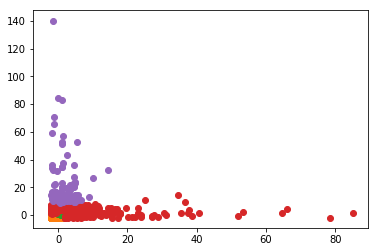

### 7. Data distribution labeled by HSMM:

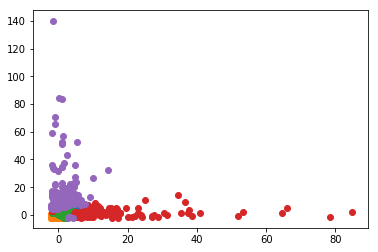

In [34]:
learning_and_labeling()